## Use PyConTurb to generate synthetic turbulent inflow velocity field ##

If you haven't already, install `pyconturb` using the instructions here: https://pyconturb.pages.windenergy.dtu.dk/pyconturb/installation.html

This notebook follows the Unconstrained Turbulence example here: https://pyconturb.pages.windenergy.dtu.dk/pyconturb/notebooks/1_unconstr_time_series.html 

In [3]:
import matplotlib.pyplot as plt  # matplotlib for some plotting
import numpy as np  # numeric python functions
import pandas as pd  # need this to load our data from the csv files

import sys
# NOTE: to run this, you will need to replace the path below #
sys.path.append('/Users/bstanisl/repos/pyconturb/pyconturb') # path to the pyconturb repository location on your local machine
from pyconturb import gen_turb, gen_spat_grid  # generate turbulence, useful helper
from pyconturb.sig_models import iec_sig  # IEC 61400-1 turbulence std dev
from pyconturb.spectral_models import kaimal_spectrum  # Kaimal spectrum
from pyconturb.wind_profiles import constant_profile, power_profile  # wind-speed profile functions

from _nb_utils import plot_slice
import h5py

In [ ]:
# generate spatial gridpoints dataframe
ny = 80
nz = 80 #40
y = np.linspace(-10.0, 10.0, ny)
z = np.linspace(0.00001, 20.0, nz) 

spat_df = gen_spat_grid(y, z)  # if `comps` not passed in, assumes all 3 components are wanted
spat_df.head()  # look at the first few rows

,u_p0,v_p0,w_p0,u_p1,v_p1,w_p1,u_p2,v_p2,w_p2,u_p3,...,w_p6396,u_p6397,v_p6397,w_p6397,u_p6398,v_p6398,w_p6398,u_p6399,v_p6399,w_p6399
k,0.00000,1.00000,2.00000,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,...,2.000000,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.0,1.0,2.0
x,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
y,-10.00000,-10.00000,-10.00000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.0
z,0.00001,0.00001,0.00001,0.253174,0.253174,0.253174,0.506339,0.506339,0.506339,0.759503,...,19.240507,19.493671,19.493671,19.493671,19.746836,19.746836,19.746836,20.0,20.0,20.0


In [ ]:
# generate time vector
t_final = 1.0 #10.0 [s]
dt = 0.01 # [s]
t_steps = int(t_final/dt)
time = np.linspace(0, t_final, t_steps)

In [ ]:
# generate turbulent velocity flow field dataframe
# NOTE: This step can take up to 30 minutes
u_ref = 20
turb_df = gen_turb(spat_df, T=t_final, dt=dt, u_ref=u_ref)
turb_df.head()

,u_p0,v_p0,w_p0,u_p1,v_p1,w_p1,u_p2,v_p2,w_p2,u_p3,...,w_p6396,u_p6397,v_p6397,w_p6397,u_p6398,v_p6398,w_p6398,u_p6399,v_p6399,w_p6399
0.0,4.546573,3.142915,0.736270,9.174638,-3.407159,-0.739441,7.627906,-3.949300,2.174219,9.618385,...,-0.780821,8.690532,-0.883842,1.501049,12.613932,-1.490979,2.045499,11.442407,3.464743,-0.955902
0.2,1.346335,-2.955881,2.169058,8.483731,-0.467436,-2.390213,11.691883,-1.226122,-0.564967,11.852898,...,-2.532348,16.119475,2.127803,0.958641,16.669781,-1.088475,-1.376993,19.397046,1.917844,1.193458
0.4,-4.374607,-0.072106,-2.333083,-0.173011,-1.267879,1.941986,2.583170,1.713110,-2.255706,4.476730,...,1.450413,16.885632,1.467120,-2.732148,19.200120,-2.911494,-1.975244,19.242093,-3.068319,0.809181
0.6,2.247058,-2.200348,-0.355774,5.464088,1.811769,0.341703,5.455402,0.787239,0.833149,2.860843,...,0.966887,18.651631,1.531907,-0.171771,14.085346,2.093165,0.771838,13.467859,-1.023364,1.390126
0.8,0.300492,2.085420,-0.216471,7.941804,3.330706,0.845965,8.126225,2.675073,-0.186695,9.673127,...,0.895869,13.295519,-4.242989,0.444229,11.263903,3.397782,0.534900,10.472029,-1.290904,-2.436863


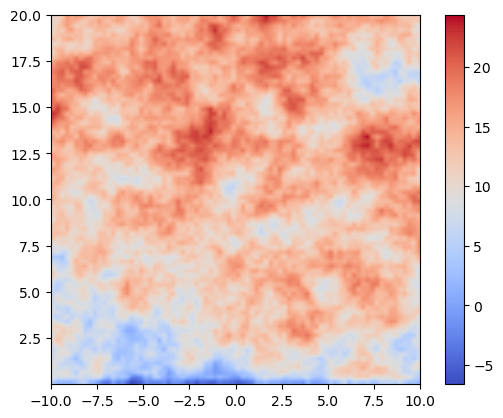

In [10]:
# reshape to 3D array and visualize first timestep
data = {}
data['u'] = turb_df.filter(regex='u').values.reshape(len(turb_df),y.size,z.size).transpose((0, 2, 1))
data['v'] = turb_df.filter(regex='v').values.reshape(len(turb_df),y.size,z.size).transpose((0, 2, 1))
data['w'] = turb_df.filter(regex='w').values.reshape(len(turb_df),y.size,z.size).transpose((0, 2, 1))

fig, ax = plt.subplots()
plt.imshow(data['u'][0,:,:],  # imshow requires nz-ny slice
            origin='lower',  # smallest y-z in lower left, not upper left
            extent=[y[0], y[-1], z[0], z[-1]],  # lateral and vertical limits
            interpolation='bilinear',
            cmap='coolwarm')  # image smoothing
plt.colorbar()

In [ ]:
# write to h5 file
h5_filename = "pct_turb_ny{}_nz{}_unconstrained_{}s_dt{}_uref{}.h5".format(
    ny, nz, t_final, dt, u_ref
)
with h5py.File("../../input/"+h5_filename, "w") as fp:
    fp.create_dataset("time_index", shape=(t_steps,))
    fp["time_index"][:] = time
    
    fp.create_dataset("y_coordinates", shape=(ny,))
    fp["y_coordinates"][:] = y
        
    fp.create_dataset("z_coordinates", shape=(nz,))
    fp["z_coordinates"][:] = z
        
    fp.create_dataset("u", shape=(t_steps, nz, ny))
    fp["u"][:] = data['u'][:]
    
    fp.create_dataset("v", shape=(t_steps, nz, ny))
    fp["v"][:] = data['v'][:]
    
    fp.create_dataset("w", shape=(t_steps, nz, ny))
    fp["w"][:] = data['w'][:]

In [ ]:
# read h5 file
# Note: Replace the path below with the path on your local machine to the .h5 file that you want to read
fname = '/Users/bstanisl/Documents/repos/PVade/input/pct_turb_ny80_nz80_unconstrained_1.0s_dt0.01_uref20.h5'

# Open the file (read-only)
with h5py.File(fname, "r") as f:
    # Explore the structure
    print("Top-level keys:", list(f.keys()))

    # print(f.visit(print))

    # Recursively print structure and types
    def show_structure(name, obj):
        print(f"{name} -> {type(obj)}")

    f.visititems(show_structure)

    # Access a dataset
    data = f["u"][:]
    print(data.shape, data.dtype)

Top-level keys: ['time_index', 'u', 'v', 'w', 'y_coordinates', 'z_coordinates']
time_index -> <class 'h5py._hl.dataset.Dataset'>
u -> <class 'h5py._hl.dataset.Dataset'>
v -> <class 'h5py._hl.dataset.Dataset'>
w -> <class 'h5py._hl.dataset.Dataset'>
y_coordinates -> <class 'h5py._hl.dataset.Dataset'>
z_coordinates -> <class 'h5py._hl.dataset.Dataset'>
(100, 80, 80) float32
